In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import re
from nltk.corpus import stopwords, wordnet
import string

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import SnowballStemmer



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# dataset from github repo
url1 = 'https://raw.githubusercontent.com/jcowper7newc/multi-class-project/main/data/train.csv'
url2 = 'https://raw.githubusercontent.com/jcowper7newc/multi-class-project/main/data/test.csv'
url3 = 'https://raw.githubusercontent.com/jcowper7newc/multi-class-project/main/data/valid.csv'

# read in as dataframes from kaggle source
train = pd.read_csv(url1)
test = pd.read_csv(url2)
val = pd.read_csv(url3)

print(train.shape)
print(test.shape) # test data does not have labels provided
print(val.shape)

test.info()

# concat labelled data
df = pd.concat([train,val])
pd.set_option('display.max_columns',None)




(52057, 3)
(17353, 2)
(17353, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17353 entries, 0 to 17352
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17353 non-null  int64 
 1   text    17353 non-null  object
dtypes: int64(1), object(1)
memory usage: 271.3+ KB


In [ ]:
# initial data exploration for use in this project
df.shape # n 86,763 p = 3 
df.info() # p = id, text, label



<class 'pandas.core.frame.DataFrame'>
Int64Index: 69410 entries, 0 to 17352
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      69410 non-null  int64 
 1   text    69410 non-null  object
 2   label   69410 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.1+ MB


No nulls or NANs within this df. Real data may have issues. At this stage errors would be further investigated. Resulting in either replacement of issues with pseudo/ correct observation or the entire row removed.

pet labels are..
['dogs' 'cats' 'fish aquatic pets' 'birds' 'bunny rabbit central'
 'small animals']


,Frequency,Proportion %
dogs,37333,54.0
cats,24661,36.0
fish aquatic pets,4789,7.0
birds,1411,2.0
bunny rabbit central,760,1.0
small animals,456,1.0


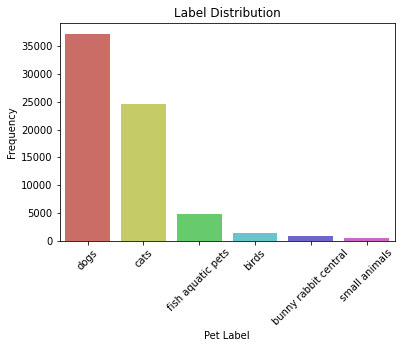

In [ ]:
# label distribution
print('pet labels are..')
print(np.asarray(sum_df.index))

# plot counts
summary['Frequency'] = pd.DataFrame(df['label'].value_counts())
summary['Proportion %'] = round(summary.label / summary.label.sum(),2)*100


g = sns.barplot(x=summary.index.values,y='label',palette = 'hls',data=summary)
g.set_ylabel('Frequency')
g.set_xlabel('Pet Label')
g.set_title('Label Distribution')
plt.xticks(rotation=45)

summary.drop(['label','proportion %'],axis=1)


We can see that label distribution is clearly imbalanced. 90% of all data is compiled of cat and dog labels. This could impact model classification later in analysis. Use original splits (as is) and also resample - oversampling minority classes to produce even splits -> compare results.

When creating validation set, important to stratify splits

In [ ]:
df.head()

# create a partition to reduce data size whilst developing
df = df.sample(frac=1,replace=False,random_state=10)

In [ ]:
# pre-processing review text
df = df.rename(columns={'text':'review'})

#df['clean_review'] = df['review'].str.lower()
#df['clean_review'] = df['clean_review'].str.replace('[^\w\s]','')
#df['clean_review'] = df['clean_review'].apply(lambda x: re.sub('[^A-Za-z]',' ',x)) # 2 options

stemmer = SnowballStemmer('english')

def process_text(text):
# lowercase
    text = text.lower()
# special characters
    text = text.replace('[^\w\s]','')
# tokenise/ punctuation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
# stopwords
    global stop
    stop = stopwords.words('english')
    #stop.extend(['add future words if irrelvant to this data'])
    text = [word for word in text if word not in stop]
# word stemming
    text = [stemmer.stem(word) for word in text]
# remove single letter words
    text = [word for word in text if len(word)>1]
# join back into review
    text = " ".join(text)
    return (text)

df['clean_review'] = df['review'].apply(lambda x: process_text(x))




print('Using '+ str(len(stop)) + ' stopwords\n\n')

df.head(5)


Using 179 stopwords




,id,review,label,clean_review
38953,38953,My 4 Siamese and 1 oriental all love the cat d...,cats,siames orient love cat dancer hide go bed can'...
38887,38887,"My 10 pound Cavalier/Bichon mix, Bailey LOVES ...",dogs,pound cavalier/bichon mix bailey love new boos...
12821,12821,This is much cheaper than a lot of the pet foo...,dogs,much cheaper lot pet food storag market work w...
49573,49573,I can't argue that this doesn't work; it does....,dogs,can't argu work expect qualiti product mat mad...
28291,28291,I purchased this crate for my large yellow lab...,dogs,purchas crate larg yellow lab troubl get hous ...


Compare how processing has changed length of reviews

In [ ]:
df['orig_review'] = pd.DataFrame(df['review'].apply(lambda x: len(x.split(' '))).astype(int))
df['proc_review'] = pd.DataFrame(df['clean_review'].apply(lambda x: len(x.split(' '))).astype(int))
df.head(2)






,id,review,label,clean_review,orig_review,proc_review
38953,38953,My 4 Siamese and 1 oriental all love the cat d...,cats,siames orient love cat dancer hide go bed can'...,78,33
38887,38887,"My 10 pound Cavalier/Bichon mix, Bailey LOVES ...",dogs,pound cavalier/bichon mix bailey love new boos...,101,50


avg original review words: 84.69851606396773
avg processed review words: 40.29312779138453


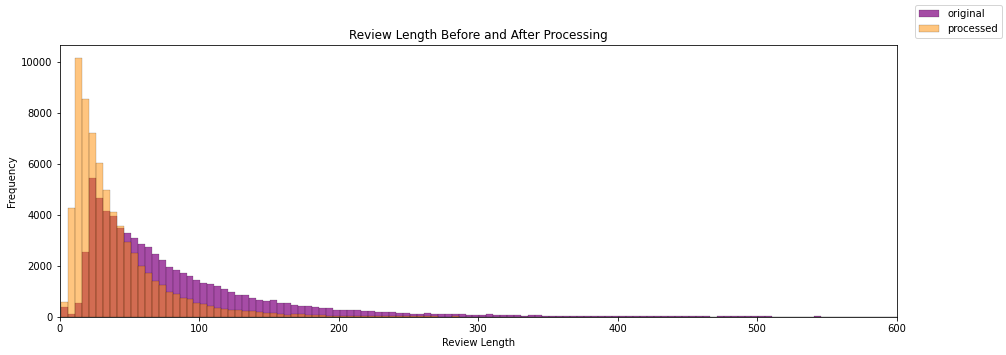

In [ ]:
print('avg original review words: '+str(df['orig_review'].mean()))
print('avg processed review words: '+str(df['proc_review'].mean()))



fig = plt.figure(figsize=(15,5))

g = sns.histplot(df['orig_review'],binwidth=5,color='purple',alpha=0.7)
g = sns.histplot(df['proc_review'],binwidth=5,alpha=0.5,color='darkorange')
fig.legend(labels=['original','processed'])
g.set_xlabel('Review Length')
g.set_ylabel('Frequency')
g.set_title('Review Length Before and After Processing')
plt.xlim(0,600)
plt.show()


Text(0, 0.5, '')

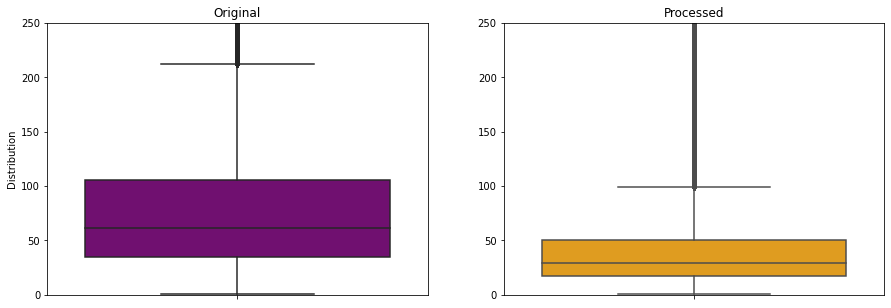

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
sns.boxplot(y='orig_review',data=df,ax=ax[0],color='purple',)
sns.boxplot(y='proc_review',data=df,ax=ax[1],color='orange')
ax[0].set_ylim(0,250) 
ax[1].set_ylim(0,250) 
ax[1].set_title('Processed')
ax[0].set_title('Original')
ax[0].set_ylabel('Distribution')
ax[1].set_ylabel('')



